In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2

from PIL import Image
import os
import json
from transformers.tokenization_auto import AutoTokenizer
from tqdm import tqdm

In [34]:
#save the val_npy into chunks
val_data = np.load("/home/zmykevin/fb_intern/data/mmf_data/datasets/cc/defaults/annotations/val_vinvl_itm_fixed.npy", allow_pickle=True)
val_data_120 = val_data[:120]
with open("/home/zmykevin/fb_intern/data/mmf_data/datasets/cc/defaults/annotations/val_vinvl_itm_fixed_120_1.npy", "wb") as f:
    np.save(f, val_data_120)
    

In [4]:
cmap = matplotlib.cm.get_cmap('jet')
cmap.set_bad(color="k", alpha=0.0)

def attention_bbox_interpolation(im, bboxes, att):
    softmax = att
    assert len(softmax) == len(bboxes)

    img_h, img_w = im.shape[:2]
    opacity = np.zeros((img_h, img_w), np.float32)
    for bbox, weight in zip(bboxes, softmax):
        x1, y1, x2, y2 = bbox
        opacity[int(y1):int(y2), int(x1):int(x2)] += weight
    opacity = np.minimum(opacity, 1)

    opacity = opacity[..., np.newaxis]
    
    vis_im = np.array(Image.fromarray(cmap(opacity, bytes=True), 'RGBA'))
    vis_im = vis_im.astype(im.dtype)
    vis_im = cv2.addWeighted(im, 0.7, vis_im, 0.5, 0)
    vis_im = vis_im.astype(im.dtype)
    
    return vis_im


def attention_grid_interpolation(im, att):
    softmax = np.reshape(att, (14, 14))
    opacity = skimage.transform.resize(softmax, im.shape[:2], order=3)
    opacity = opacity[..., np.newaxis]
    opacity = opacity*0.95+0.05

    vis_im = opacity*im + (1-opacity)*255
    vis_im = vis_im.astype(im.dtype)
    return vis_im

def visualize_pred(im_path, boxes, att_weights):
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    b,g,r,a = cv2.split(im)           # get b, g, r
    im = cv2.merge([r,g,b,a])

#     M = min(len(boxes), len(att_weights))
#     im_ocr_att = attention_bbox_interpolation(im, boxes[:M], att_weights[:M])
#     plt.imshow(im_ocr_att)

def draw_image_bb(attention_scores, txt_input_ids, img_bb, id_,
                  image_fname, output_folder, i2t=False, toker=None):

    I = np.array(Image.open(image_fname), dtype=np.uint8)
    image_w, image_h = I.shape[0], I.shape[1]
    '''
    box_width = bboxes[:, 2] - bboxes[:, 0]
    box_height = bboxes[:, 3] - bboxes[:, 1]
    scaled_width = box_width / image_w
    scaled_height = box_height / image_h
    scaled_x = bboxes[:, 0] / image_w
    scaled_y = bboxes[:, 1] / image_h
    box_width = box_width[..., np.newaxis]
    box_height = box_height[..., np.newaxis]
    scaled_width = scaled_width[..., np.newaxis]
    scaled_height = scaled_height[..., np.newaxis]
    scaled_x = scaled_x[..., np.newaxis]
    scaled_y = scaled_y[..., np.newaxis]
    normalized_bbox = np.concatenate(
        (scaled_x,
            scaled_y,
            scaled_x + scaled_width,
            scaled_y + scaled_height,
            scaled_width,
            scaled_height),
        axis=1)
    '''
    img_bb = img_bb.squeeze()
    img_bb[:, 0] *= image_h
    img_bb[:, 1] *= image_w
    img_bb[:, 2] *= image_h
    img_bb[:, 3] *= image_w
    img_bb = img_bb[:, :4].cpu().numpy()

    txt_input_ids = txt_input_ids.squeeze().cpu().tolist()
    txt_len = len(txt_input_ids)
    # toker = BertTokenizer.from_pretrained(
    #         "bert-base-cased", do_lower_case=False)
    padded_tokens = toker.convert_ids_to_tokens(txt_input_ids)
    tok_inds = [i for i, tok in enumerate(padded_tokens)]
                # if '[' not in tok]
    tokens = [padded_tokens[i] for i in tok_inds]
    attention_scores = [att.cpu() for att in attention_scores]
    num_bb = attention_scores[0].shape[-1] - len(padded_tokens)

    for layer_num in range(len(attention_scores)):
        for head_num in range(attention_scores[0].shape[1]):
            attention = attention_scores[layer_num]
            attention = attention[0, head_num, :, :]
            if i2t:
                attention = attention[txt_len:, :txt_len]
                attention = attention[:, tok_inds]
                output_name = "i2t"
            else:
                attention = attention[:txt_len, txt_len:]
                attention = attention[tok_inds, :]
                # attention = attention.transpose(0, 1)
                output_name = "t2i"
                for t_id in range(attention.shape[0]):
                    tok = tokens[t_id]
                    #Only from the tok around the CLS
                    if tok != "[CLS]":
                        continue
                    att = attention[t_id, :]
                    inds = att.argsort().tolist()[::-1]
                    att, bb = att[inds].numpy(), img_bb[inds]

                    fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1)
                    plt.axis('off')
                    A = np.zeros((image_w, image_h, 1))
                    for bb_id in range(len(att)):
                        current_bb = bb[bb_id].astype(int)
                        A[current_bb[1]:current_bb[3],
                          current_bb[0]:current_bb[2]] += att[bb_id]
                    A /= np.max(A)
                    A = A * I + (1.0-A)*255
                    A = A.astype('uint8')
                    # top_bb = bb[0].astype(int)
                    # ax.add_patch(
                    #     plt.Rectangle((top_bb[1], top_bb[0]),
                    #                   top_bb[3] - top_bb[1],
                    #                   top_bb[2] - top_bb[0],
                    #                   fill=False, edgecolor='red',
                    #                   linewidth=1))
                   
                    plt.imshow(A, interpolation='bicubic')
                    plt.suptitle(f"{layer_num}_{head_num}_{tok}", x=0.5, y=1)
                    plt.axis('off')
                    plt.tight_layout()
                    plt.savefig(
                        f"{output_folder}/{id_}_{layer_num}_"
                        f"{head_num}_{output_name}_{t_id}_{tok}.png")
                    plt.close()

/home/zmykevin/miniconda3/envs/mmf/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  


In [2]:
CC_Val_Image_Path = "/home/zmykevin/fb_intern/data/mingyang_data/cc_val_images"
image_files = os.listdir(CC_Val_Image_Path)

#flickr30k_images=""
#import ths cc_object_list
with open("/home/zmykevin/fb_intern/data/mingyang_data/CC/cc_objects_captions.json", "r") as f:
    cc_objects_captions = json.load(f)
    
#Load the Validation Annotation
#with open("/fsx/zmykevin/data/mmf_data/datasets/cc/defaults/annotations/val_vinvl_itm_fixed.npy", "r") as f:
annotation=np.load("/home/zmykevin/fb_intern/data/mmf_data/datasets/cc/defaults/annotations/val_vinvl_itm_fixed.npy",allow_pickle=True)


In [58]:
#Load the saved info
output_dir="/home/zmykevin/fb_intern/data/attention_viz/mu_vla"
#output_dir="/fsx/zmykevin/experiments/attention_viz/ucla"
attention_weights = np.load(os.path.join(output_dir, "attention_weights_1.npy"))
bbox = np.load(os.path.join(output_dir, "input_bbox_1.npy"))
input_ids = np.load(os.path.join(output_dir, "input_ids_1.npy"))
input_masks = np.load(os.path.join(output_dir, "input_masks_1.npy"))
input_num_boxes = np.load(os.path.join(output_dir, "input_numboxes_1.npy"))

#Load the image  ids
image_ids = json.load(open(os.path.join(output_dir,"image_ids_1.json"), "r"))
#print(image_ids)

In [6]:
x = 3318448
X = cc_objects_captions[str(x)]
print(X)


{'objects': 'sky jean jacket helmet jean boot helmet motorcycle grass mirror jacket box jean cloud person wheel man road grass pipe tire tire grass wheel shadow exhaust pipe sky field tree bike woman light letter shoe couple ground grass cloud motorcycle', 'objects_no_rep': 'man shadow box exhaust pipe jean mirror bike motorcycle woman field jacket wheel pipe letter ground helmet road shoe tire person sky couple cloud light tree grass boot', 'caption': 'person in a leather jacket riding a motorcycle on the road', 'cc_id': 2867311498, 'object_list': ['sky', 'jean', 'jacket', 'helmet', 'jean', 'boot', 'helmet', 'motorcycle', 'grass', 'mirror', 'jacket', 'box', 'jean', 'cloud', 'person', 'wheel', 'man', 'road', 'grass', 'pipe', 'tire', 'tire', 'grass', 'wheel', 'shadow', 'exhaust pipe', 'sky', 'field', 'tree', 'bike', 'woman', 'light', 'letter', 'shoe', 'couple', 'ground', 'grass', 'cloud', 'motorcycle']}


In [60]:
toker = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
MAX_SIZE = 1333
MIN_SIZE = 800

for sample_index, sample_image_id in tqdm(enumerate(image_ids)):
    sample_object_info = cc_objects_captions[str(sample_image_id)]
    #print(sample_object_info)
    sample_cc_id = sample_object_info['cc_id']
    #print(sample_cc_id)
    if sample_cc_id is None:
        continue
    sample_im_path = os.path.join(CC_Val_Image_Path, str(sample_cc_id))
    sample_caption = sample_object_info['caption'][0]
    #print(sample_caption)
    im = Image.open(sample_im_path)
    # im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    # b,g,r,a = cv2.split(im)           # get b, g, r
    # im = cv2.merge([r,g,b,a])
    plt.imshow(im)
    plt.savefig(f"{output_dir}/image/{sample_image_id}.png")
    plt.close()
    
    I = np.array(Image.open(sample_im_path), dtype=np.uint8)
    image_w, image_h = I.shape[0], I.shape[1]
    im_size_min = np.min([image_w,image_h])
    im_size_max = np.max([image_w,image_h])

    # Scale based on minimum size
    im_scale = MIN_SIZE / im_size_min

    # Prevent the biggest axis from being more than max_size
    # If bigger, scale it down
    if np.round(im_scale * im_size_max) > MAX_SIZE:
        im_scale = MAX_SIZE / im_size_max

    img_bb = bbox[sample_index].copy()
    img_bb = img_bb.squeeze()
    img_bb[:, 0] *= image_h
    img_bb[:, 1] *= image_w
    img_bb[:, 2] *= image_h
    img_bb[:, 3] *= image_w
    #img_bb = img_bb*im_scale
    img_bb = img_bb[:, :4]*im_scale
    #print(img_bb)
    txt_input_ids = input_ids[sample_index].copy()
    txt_input_masks = input_masks[sample_index].copy()
    txt_len=np.sum(txt_input_masks)
    #print(txt_len)
    #num_box = input_ids[sample_index][num_box]

    padded_tokens = toker.convert_ids_to_tokens(txt_input_ids)
    tok_inds = [i for i, tok in enumerate(padded_tokens)]
    tokens = [padded_tokens[i] for i in tok_inds]

    #print(tokens)

    attention_scores = [att[sample_index].copy() for att in attention_weights]
    num_bb = input_num_boxes[sample_index]
    #print(attention_scores[0].shape)
    mean_layer = sum(attention_scores)/len(attention_scores)
    mean_header = np.mean(mean_layer, axis=0)

    attention = mean_header[:txt_len, 60:60+num_bb]
    for t_id in range(attention.shape[0]):
        tok = tokens[t_id]
        if tok == "[CLS]":
            continue
        att = attention[t_id,:]
        inds = att.argsort().tolist()[::-1]
        att, bb = att[inds], img_bb[inds]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.axis('off')
        A = np.zeros((image_w, image_h, 1))
        for bb_id in range(len(att)):
            current_bb = bb[bb_id].astype(int)
            A[current_bb[1]:current_bb[3],
              current_bb[0]:current_bb[2]] += att[bb_id]
        A /= np.max(A)
        A = A * I + (1.0-A)*255
        A = A.astype('uint8')
        plt.imshow(A, interpolation='bicubic')
        #plt.suptitle(f"{layer_num}_{head_num}_{tok}", x=0.5, y=1)
        plt.axis('off')
        plt.tight_layout()

        plt.savefig(
                    f"{output_dir}/image/{sample_image_id}"
                    f"{t_id}_{tok}.png", bbox_inches='tight')
        plt.close()
    #break
    

120it [08:27,  4.23s/it]


{'objects': 'sky cloud cloud cloud cloud sky cloud cloud cloud cloud cloud cloud cloud cloud cloud cloud cloud cloud', 'objects_no_rep': 'cloud sky', 'caption': 'scattered clouds moving rapidly in blue skies reflecting the sunrise , then vanishing to clear skies', 'cc_id': 707769663, 'object_list': ['sky', 'cloud', 'cloud', 'cloud', 'cloud', 'sky', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud', 'cloud']}
s


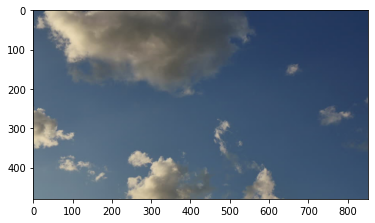

In [44]:
sample_index = 6
# sample_image = annotation[sample_index]
#print(sample_image)
sample_image_id = image_ids[sample_index]
sample_object_info = cc_objects_captions[str(sample_image_id)]
print(sample_object_info)
sample_cc_id = sample_object_info['cc_id']
sample_im_path = os.path.join(CC_Val_Image_Path, str(sample_cc_id))
sample_caption = sample_object_info['caption'][0]
print(sample_caption)
im = Image.open(sample_im_path)
# im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
# b,g,r,a = cv2.split(im)           # get b, g, r
# im = cv2.merge([r,g,b,a])
plt.imshow(im)
plt.savefig(f"{output_dir}/image/{sample_image_id}.png")
#plt.close()

#Plot the figures
toker = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [45]:
print(sample_image_id)

3318407


In [46]:
MAX_SIZE = 1333
MIN_SIZE = 800

I = np.array(Image.open(sample_im_path), dtype=np.uint8)
image_w, image_h = I.shape[0], I.shape[1]
print(image_w)
print(image_h)
im_size_min = np.min([image_w,image_h])
im_size_max = np.max([image_w,image_h])

# Scale based on minimum size
im_scale = MIN_SIZE / im_size_min

# Prevent the biggest axis from being more than max_size
# If bigger, scale it down
if np.round(im_scale * im_size_max) > MAX_SIZE:
    im_scale = MAX_SIZE / im_size_max
print(im_scale)
    
img_bb = bbox[sample_index].copy()
img_bb = img_bb.squeeze()
img_bb[:, 0] *= image_h
img_bb[:, 1] *= image_w
img_bb[:, 2] *= image_h
img_bb[:, 3] *= image_w
#img_bb = img_bb*im_scale
img_bb = img_bb[:, :4]*im_scale
#print(img_bb)
txt_input_ids = input_ids[sample_index].copy()
txt_input_masks = input_masks[sample_index].copy()
txt_len=np.sum(txt_input_masks)
#print(txt_len)
#num_box = input_ids[sample_index][num_box]

padded_tokens = toker.convert_ids_to_tokens(txt_input_ids)
tok_inds = [i for i, tok in enumerate(padded_tokens)]
tokens = [padded_tokens[i] for i in tok_inds]

#print(tokens)

attention_scores = [att[sample_index].copy() for att in attention_weights]
num_bb = input_num_boxes[sample_index]
#print(attention_scores[0].shape)
mean_layer = sum(attention_scores)/len(attention_scores)
mean_header = np.mean(mean_layer, axis=0)

attention = mean_header[:txt_len, 60:60+num_bb]
for t_id in tqdm(range(attention.shape[0])):
    tok = tokens[t_id]
    if tok == "[CLS]":
        continue
    att = attention[t_id,:]
    inds = att.argsort().tolist()[::-1]
    att, bb = att[inds], img_bb[inds]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.axis('off')
    A = np.zeros((image_w, image_h, 1))
    for bb_id in range(len(att)):
        current_bb = bb[bb_id].astype(int)
        A[current_bb[1]:current_bb[3],
          current_bb[0]:current_bb[2]] += att[bb_id]
    A /= np.max(A)
    A = A * I + (1.0-A)*255
    A = A.astype('uint8')
    plt.imshow(A, interpolation='bicubic')
    #plt.suptitle(f"{layer_num}_{head_num}_{tok}", x=0.5, y=1)
    plt.axis('off')
    plt.tight_layout()

    plt.savefig(
                f"{output_dir}/image/{sample_image_id}_"
                f"{t_id}_{tok}.png", bbox_inches='tight')
    plt.close()

# #print(attention_scores[0].shape)
# for layer_num in tqdm(range(len(attention_scores))):
#     for head_num in range(attention_scores[0].shape[0]):
#         attention = attention_scores[layer_num]
#         attention = attention[head_num,:,:]
#         attention = attention[:txt_len, 60:60+num_bb]
#         for t_id in range(attention.shape[0]):
#             tok = tokens[t_id]
#             if tok == "[CLS]":
#                 continue
#             att = attention[t_id,:]
#             inds = att.argsort().tolist()[::-1]
#             att, bb = att[inds], img_bb[inds]
            
#             fig = plt.figure()
#             ax = fig.add_subplot(1, 1, 1)
#             plt.axis('off')
#             A = np.zeros((image_w, image_h, 1))
#             for bb_id in range(len(att)):
#                 current_bb = bb[bb_id].astype(int)
#                 A[current_bb[1]:current_bb[3],
#                   current_bb[0]:current_bb[2]] += att[bb_id]
#             A /= np.max(A)
#             A = A * I + (1.0-A)*255
#             A = A.astype('uint8')
#             plt.imshow(A, interpolation='bicubic')
#             #plt.suptitle(f"{layer_num}_{head_num}_{tok}", x=0.5, y=1)
#             plt.axis('off')
#             plt.tight_layout()
            
#             plt.savefig(
#                         f"{output_dir}/image/{sample_image_id}_{layer_num}_"
#                         f"{head_num}_{t_id}_{tok}.png", bbox_inches='tight')
#             plt.close()
            #break
            #print(att)
            #print(bb)
#         break
#     break

480
852
1.5645539906103287
['[CLS]', 'scattered', 'clouds', 'moving', 'rapidly', 'in', 'blue', 'skies', 'reflecting', 'the', 'sunrise', ',', 'then', 'vanishing', 'to', 'clear', 'skies', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


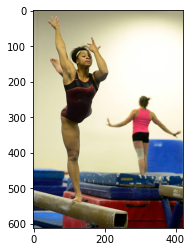

In [62]:
#Things to Confirm
#1. Check attention map and verify its dimension
#2. Check bbox and its associated bbox region, make sure we can draw the right bbox
#3. Plot the attention map onto the image;
for x in image_files:
    im_path = os.path.join(CC_Val_Image_Path, x)
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    b,g,r,a = cv2.split(im)           # get b, g, r
    im = cv2.merge([r,g,b,a])
    plt.imshow(im)
    break

In [ ]:
#Now we want to 